In [1]:
import os
import torch

from vllm import LLM, SamplingParams
from math_verify import parse, verify

import pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np


/opt/anaconda/envs/dfr/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 12-07 12:38:14 [__init__.py:239] Automatically detected platform cuda.


2025-12-07 12:38:17,681	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# MODEL_NAME = "allenai/Olmo-3-7B-Think"
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B"
# MODEL_NAME = "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
MODEL_ALIAS = MODEL_NAME.split("/")[-1]
splits = ["train", "test"]
NUM_ROLLOUTS_PER_QUESTION = 50

In [6]:
train_df_3k = pd.read_parquet("MATH_Qwen2.5-Math-1.5B-SR_train_3000.parquet")
train_df_1024 = pd.read_parquet("MATH_Qwen2.5-Math-1.5B-SR_train.parquet")

test_df_3k = pd.read_parquet("MATH_Qwen2.5-Math-1.5B-SR_test_3000.parquet")
test_df_1024 = pd.read_parquet("MATH_Qwen2.5-Math-1.5B-SR_test.parquet")

In [ ]:
DATA_PATH = f"MATH_{MODEL_ALIAS}-SR_train.parquet"
MATH_DATA_PATH = "../hard_rl/data/MATH/{}.jsonl"
train_df = pd.read_parquet(DATA_PATH)
og_math_train_df = pd.read_json(MATH_DATA_PATH.format("train"), lines=True)
DATA_PATH = f"MATH_{MODEL_ALIAS}-SR_test.parquet"
test_df = pd.read_parquet(DATA_PATH)
og_math_test_df = pd.read_json(MATH_DATA_PATH.format("validation"), lines=True)

In [129]:
len(train_df), len(test_df)

(11999, 500)

In [130]:
len(og_math_train_df), len(og_math_test_df)

(12000, 500)

In [131]:
og_math_train_df["prompt"] = og_math_train_df["problem"]
solving_str = ' Let\'s think step by step and output the final answer after "\\boxed{}".'
og_math_train_df["prompt"] = og_math_train_df["prompt"].apply(lambda x: x + solving_str)

In [135]:
og_math_train_df["prompt"].iloc[0]

'How many vertical asymptotes does the graph of $y=\\frac{2}{x^2+x-6}$ have? Let\'s think step by step and output the final answer after "\\boxed{}".'

In [146]:
train_df["token_len"] = train_df["prompt"].apply(lambda x: len(tokenizer.encode(x)) )
# og_math_test_df["token_len"] = og_math_test_df["prompt"].apply(lambda x: len(tokenizer.encode(x)) )

In [150]:
train_df["token_len"].describe()

count    11999.000000
mean        87.778565
std         87.748261
min         22.000000
25%         47.000000
50%         63.000000
75%         92.000000
max       1669.000000
Name: token_len, dtype: float64

In [139]:
len(tokenizer.encode(og_math_train_df["prompt"].iloc[0]))

40

In [58]:
train_prompts, og_train_prompts = train_df["prompt"].tolist(), og_math_train_df["prompt"].tolist()

In [59]:
len(train_prompts), len(og_train_prompts)

(11999, 12000)

In [60]:
len(set(train_prompts))

11999

In [63]:
STORE = []
for prompt in og_train_prompts:
    if prompt not in train_prompts:
        print(prompt)

In [66]:
# Find which prompt(s) from og_train_prompts are missing in train_prompts
missing_prompts = [p for p in og_train_prompts if p not in train_prompts]
print(f"Number of missing prompts: {len(missing_prompts)}")

# Also check for duplicates in train_df
print(f"\nUnique prompts in train_df: {train_df['prompt'].nunique()}")
print(f"Total prompts in train_df: {len(train_df)}")

# Check for duplicates
duplicates = train_df[train_df.duplicated(subset=['prompt'], keep=False)]
print(f"\nNumber of duplicate rows in train_df: {len(duplicates)}")

if len(missing_prompts) > 0:
    print("\n--- Missing prompt(s) ---")
    for i, p in enumerate(missing_prompts):
        print(f"\n[{i+1}] {p[:200]}...")  # Print first 200 chars
        # Find the original row
        matching_row = og_math_train_df[og_math_train_df['prompt'] == p]
        if len(matching_row) > 0:
            print(f"unique_id: {matching_row['unique_id'].values}")
            print(f"subject: {matching_row['subject'].values}")

Number of missing prompts: 0

Unique prompts in train_df: 11999
Total prompts in train_df: 11999

Number of duplicate rows in train_df: 0


In [67]:
# Check for duplicates in og_math_train_df
print(f"Unique prompts in og_math_train_df: {og_math_train_df['prompt'].nunique()}")
print(f"Total prompts in og_math_train_df: {len(og_math_train_df)}")

# Find the duplicate(s)
og_duplicates = og_math_train_df[og_math_train_df.duplicated(subset=['prompt'], keep=False)]
print(f"\nNumber of duplicate rows in og_math_train_df: {len(og_duplicates)}")

if len(og_duplicates) > 0:
    print("\n--- Duplicate prompt(s) in original MATH dataset ---")
    print(og_duplicates[['unique_id', 'subject', 'prompt']].to_string())

Unique prompts in og_math_train_df: 11999
Total prompts in og_math_train_df: 12000

Number of duplicate rows in og_math_train_df: 2

--- Duplicate prompt(s) in original MATH dataset ---
                         unique_id   subject                                                                                                                                                                                          prompt
2336   test/precalculus/24307.json  Geometry  The points $(0,0)\,$, $(a,11)\,$, and $(b,37)\,$ are the vertices of an equilateral triangle. Find the value of $ab\,$. Let's think step by step and output the final answer after "\boxed{}".
11794  test/precalculus/24307.json  Geometry  The points $(0,0)\,$, $(a,11)\,$, and $(b,37)\,$ are the vertices of an equilateral triangle. Find the value of $ab\,$. Let's think step by step and output the final answer after "\boxed{}".


In [44]:
print(train_df["prompt"].iloc[3])

Tamantha wants to buy boxes in which to put her 77 compact discs. If each box holds 12 discs, how many does she need to buy? Let's think step by step and output the final answer after "\boxed{}".


In [27]:
train_df.head()

,correct,total,success_rate,prompt,ground_truth
id,,,,,
1,50,50,1.0,Simplify $\frac{100}{180}$. Let's think step b...,None
2,50,50,1.0,What is $1 + 2 + 3 + \cdots + 98 + 99 + 100$? ...,None
3,50,50,1.0,What is the smallest multiple of 6 greater tha...,None
4,50,50,1.0,What is the greatest two-digit multiple of 13?...,None
5,50,50,1.0,Compute $\tan 0^\circ$. Let's think step by st...,None


In [104]:
# aggregate og_math_train_df by prompt to collect all matching unique_ids and subjects
agg = og_math_train_df.groupby("prompt").agg({
    "unique_id": lambda s: list(s.unique()),
    "subject":   lambda s: list(s.unique())
}).reset_index()

# merge with train_df (preserve train_df index if it is meaningful)
merged = train_df.reset_index().merge(agg, on="prompt", how="left").set_index(train_df.index.name or "id")

# inspect match counts and a sample
print("matched rows:", merged["unique_id"].notna().sum(), "of", len(merged))
merged[["prompt", "unique_id", "subject"]].head()

# keep only the recorded ids/subjects (rows without matches will have NaN)
matched_info = merged[["unique_id", "subject"]]

# optionally save
# matched_info.to_parquet("train_matched_unique_ids_subjects.parquet")
# rows without matches: either NaN or empty list
cond_no_match = merged["unique_id"].isna() | merged["unique_id"].apply(lambda x: isinstance(x, (list, tuple)) and len(x) == 0)

didnt_match = merged[cond_no_match].copy()

print("didn't match rows:", len(didnt_match), "of", len(merged))
didnt_match[["prompt", "correct", "total", "success_rate", "unique_id", "subject"]].head()


matched rows: 11999 of 11999
didn't match rows: 0 of 11999


,prompt,correct,total,success_rate,unique_id,subject
id,,,,,,


In [105]:
merged

,correct,total,success_rate,ground_truth,prompt,unique_id,subject
id,,,,,,,
1,50,50,1.0,None,What is the greatest common factor of 252 and ...,[train/prealgebra/624.json],[Prealgebra]
2,50,50,1.0,None,If $\det \mathbf{A} = 4$ and $\det \mathbf{B} ...,[test/precalculus/423.json],[Precalculus]
3,50,50,1.0,None,In how many ways can a 2-person committee be c...,[test/prealgebra/885.json],[Prealgebra]
4,50,50,1.0,None,Tamantha wants to buy boxes in which to put he...,[test/prealgebra/838.json],[Prealgebra]
5,50,50,1.0,None,Ten distinct points are identified on the circ...,[train/counting_and_probability/618.json],[Counting & Probability]
...,...,...,...,...,...,...,...
11995,0,50,0.0,None,"If $x$ is an odd number, then find the largest...",[train/number_theory/7120.json],[Number Theory]
11996,0,50,0.0,None,The isosceles triangle and the square shown he...,[train/prealgebra/81.json],[Prealgebra]
11997,0,50,0.0,None,Two cards are dealt at random from a standard ...,[train/counting_and_probability/722.json],[Counting & Probability]


In [106]:
merged["subject"].value_counts()

subject
[Algebra]                   2807
[Intermediate Algebra]      2101
[Prealgebra]                1994
[Number Theory]             1347
[Geometry]                  1308
[Precalculus]               1235
[Counting & Probability]    1207
Name: count, dtype: int64

<Axes: >

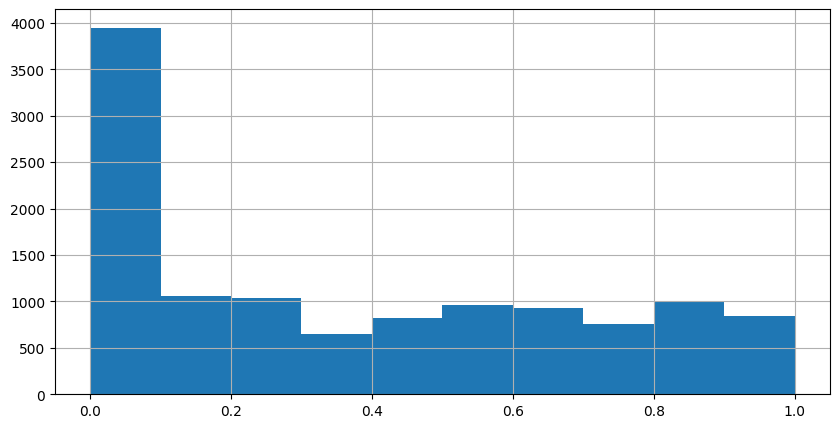

In [109]:
merged["success_rate"].hist(figsize=(10, 5))

Total bars: 11999.0


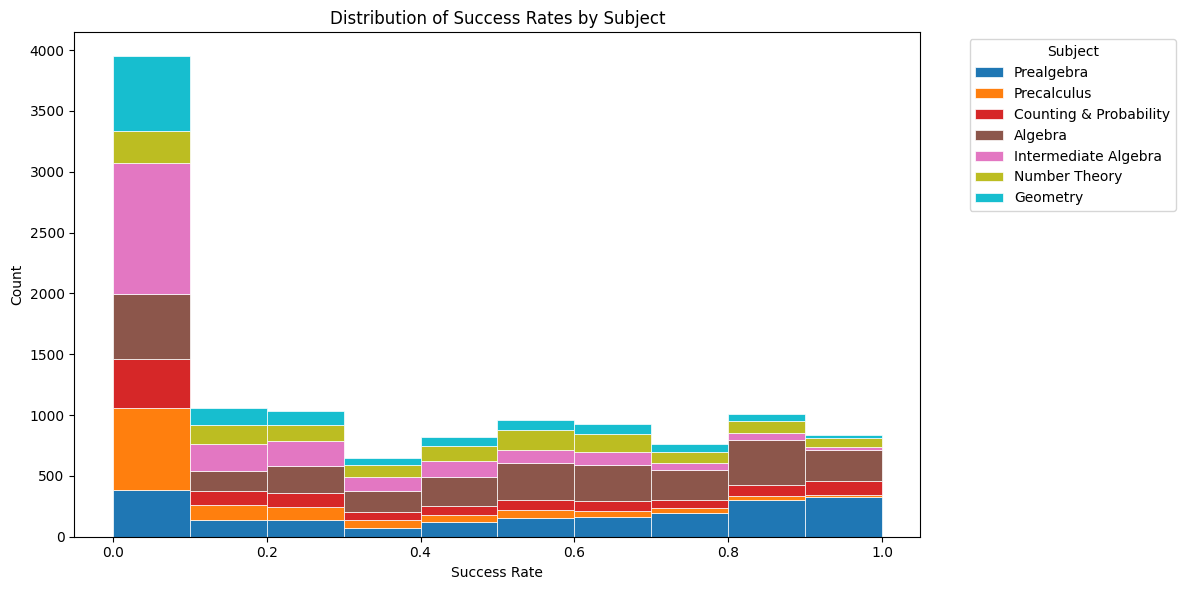

In [111]:
# Extract the first subject for each row
merged_plot = merged.copy()
merged_plot["subject_single"] = merged_plot["subject"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else "Unknown")

# Get unique subjects and assign colors
subjects = merged_plot["subject_single"].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(subjects)))

fig, ax = plt.subplots(figsize=(12, 6))

# Use 10 bins like pandas default histogram
bins = np.linspace(0, 1, 11)
bottom = np.zeros(len(bins) - 1)

for subject, color in zip(subjects, colors):
    subset = merged_plot[merged_plot["subject_single"] == subject]["success_rate"]
    counts, _ = np.histogram(subset, bins=bins)
    ax.bar(bins[:-1], counts, width=0.1, bottom=bottom, label=subject, color=color, align='edge', edgecolor='white', linewidth=0.5)
    bottom += counts

# Verify total
print(f"Total bars: {bottom.sum()}")

ax.set_xlabel("Success Rate")
ax.set_ylabel("Count")
ax.set_title("Distribution of Success Rates by Subject")
ax.legend(title="Subject", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [123]:
only_fails = merged[merged["success_rate"] <= 0.0]
only_pass = merged[merged["success_rate"] == 1.0]

In [124]:
only_fails["subject"].value_counts()

subject
[Intermediate Algebra]      672
[Precalculus]               454
[Geometry]                  373
[Algebra]                   342
[Counting & Probability]    239
[Prealgebra]                231
[Number Theory]             114
Name: count, dtype: int64

In [125]:
only_pass["subject"].value_counts()

subject
[Prealgebra]                10
[Counting & Probability]     6
[Algebra]                    2
[Precalculus]                1
Name: count, dtype: int64

/tmp/ipykernel_159006/3526043235.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_stats = merged_plot.groupby("token_len_bin")["success_rate"].agg(['mean', 'std', 'count'])


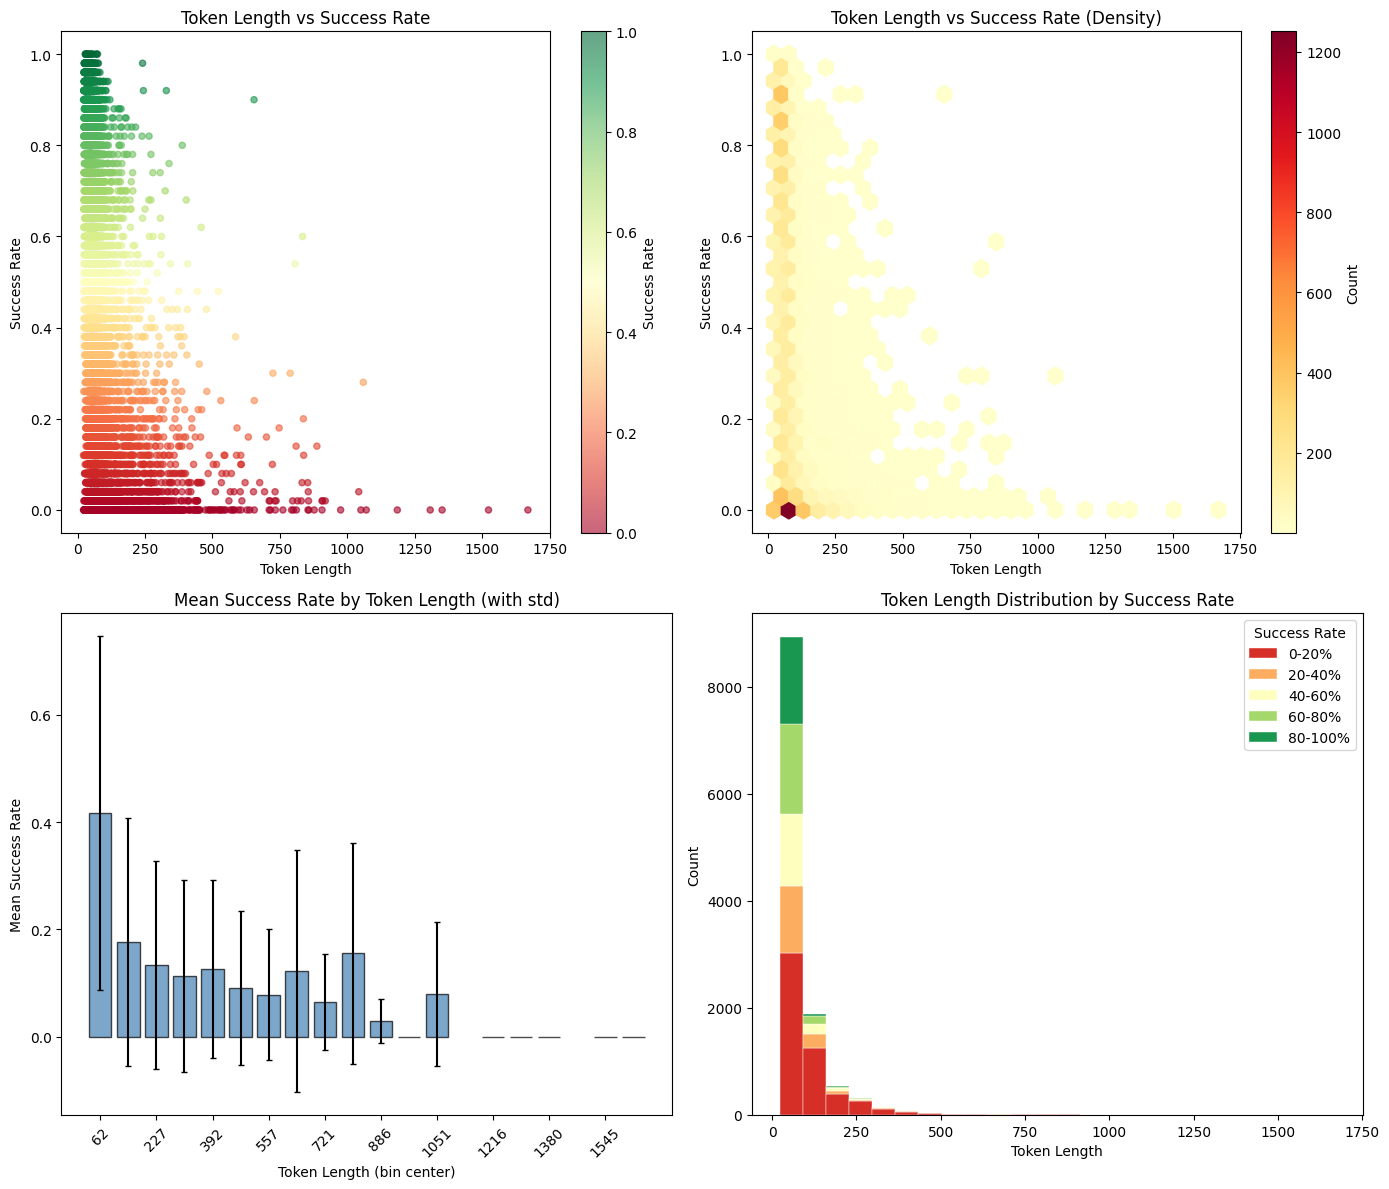


Correlation between token length and success rate: -0.3037


In [149]:
# Visualize relationship between token length and success rate
# Add token_len to merged df
merged_plot = merged.copy()
merged_plot["token_len"] = merged_plot["prompt"].apply(lambda x: len(tokenizer.encode(x)))

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Scatter plot with color gradient by success rate
ax1 = axes[0, 0]
scatter = ax1.scatter(merged_plot["token_len"], merged_plot["success_rate"], 
                      c=merged_plot["success_rate"], cmap='RdYlGn', alpha=0.6, s=20)
ax1.set_xlabel("Token Length")
ax1.set_ylabel("Success Rate")
ax1.set_title("Token Length vs Success Rate")
plt.colorbar(scatter, ax=ax1, label="Success Rate")

# 2. Hexbin plot (2D histogram) - better for dense data
ax2 = axes[0, 1]
hb = ax2.hexbin(merged_plot["token_len"], merged_plot["success_rate"], 
                gridsize=30, cmap='YlOrRd', mincnt=1)
ax2.set_xlabel("Token Length")
ax2.set_ylabel("Success Rate")
ax2.set_title("Token Length vs Success Rate (Density)")
plt.colorbar(hb, ax=ax2, label="Count")

# 3. Binned average success rate by token length
ax3 = axes[1, 0]
merged_plot["token_len_bin"] = pd.cut(merged_plot["token_len"], bins=20)
binned_stats = merged_plot.groupby("token_len_bin")["success_rate"].agg(['mean', 'std', 'count'])
bin_centers = [interval.mid for interval in binned_stats.index]
ax3.bar(range(len(bin_centers)), binned_stats['mean'], yerr=binned_stats['std'], 
        capsize=2, alpha=0.7, color='steelblue', edgecolor='black')
ax3.set_xticks(range(0, len(bin_centers), 2))
ax3.set_xticklabels([f"{int(bin_centers[i])}" for i in range(0, len(bin_centers), 2)], rotation=45)
ax3.set_xlabel("Token Length (bin center)")
ax3.set_ylabel("Mean Success Rate")
ax3.set_title("Mean Success Rate by Token Length (with std)")

# 4. Stacked histogram of token lengths colored by success rate bins
ax4 = axes[1, 1]
# Bin success rates into categories
sr_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
sr_labels = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
merged_plot["sr_bin"] = pd.cut(merged_plot["success_rate"], bins=sr_bins, labels=sr_labels, include_lowest=True)

# Create stacked histogram
colors = plt.cm.RdYlGn(np.linspace(0.1, 0.9, len(sr_labels)))
token_bins = np.linspace(merged_plot["token_len"].min(), merged_plot["token_len"].max(), 25)
bottom = np.zeros(len(token_bins) - 1)

for label, color in zip(sr_labels, colors):
    subset = merged_plot[merged_plot["sr_bin"] == label]["token_len"]
    counts, _ = np.histogram(subset, bins=token_bins)
    ax4.bar(token_bins[:-1], counts, width=np.diff(token_bins), bottom=bottom, 
            label=label, color=color, align='edge', edgecolor='white', linewidth=0.3)
    bottom += counts

ax4.set_xlabel("Token Length")
ax4.set_ylabel("Count")
ax4.set_title("Token Length Distribution by Success Rate")
ax4.legend(title="Success Rate", loc='upper right')

plt.tight_layout()
plt.show()

# Print correlation
corr = merged_plot["token_len"].corr(merged_plot["success_rate"])
print(f"\nCorrelation between token length and success rate: {corr:.4f}")